In [1]:
import pandas as pd
import itertools
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def lookup_description(tag_list):
    for tag in tag_list:
        try:
            print(f"{tag}: {newcodes.loc[tag]['Description']}")
        except KeyError:
            try:
                print(f"{tag}: {n2k.loc[tag]['Description']}")
            except KeyError:
                lst = [i for i in newcodes.index if str(i).startswith(tag)]
                if len(lst) == 1:
                    print(f"{lst[0]}: {newcodes.loc[lst[0]]['Description']}")
                elif lst:
                    lst = [i for i in newcodes.index if str(i).startswith(tag[:-1])]
                    if len(lst) == 1:
                        print(f"{lst[0]}: {newcodes.loc[lst[0]]['Description']}")
                    elif lst:
                        print(lst)
                    else:
                        print(tag)

In [2]:
n2k = pd.read_excel('N2K_Template_2015-06-08.xls', index_col=0)
newcodes = pd.read_excel('4_NewsCodes_20170927.xls', index_col=0)

missingTags = torch.load('missingTags.pt')
missingTags_list = list(itertools.chain.from_iterable(missingTags.values()))
print(f"Number of possible missing tags: {len(set(missingTags_list))}")

Number of possible missing tags: 711


Mismatching in the old and new selected articles are <b>not</b> caused by:
- upper/lower-case tags
- missing values in headlines
- missing values in any columns
- duplicate entries in headlines
- duplicate entries in all columns
- rare bugs when converting strings to lists

# Greedy Explanation over Monthly Observations

In [3]:
print(f"Number of mismatching months to be explaned by missing tags: {len(missingTags)}")
c = Counter(missingTags_list)
print(f"Most common missing tags       : {c.most_common(5)}")

Number of mismatching months to be explaned by missing tags: 154
Most common missing tags       : [('NSEA', 95), ('LPG', 92), ('RFOD', 85), ('ENQ', 65), ('OSTR', 51)]


In [4]:
lookup_description(['NSEA', 'LPG', 'RFOD', 'RENQ'])

NSEA: North Sea Oil
LPG1: Liquefied Petroleum Gas
RFOD: Food Distribution & Convenience Stores (TRBC)
RENQ: Renewable Energy Equipment & Services (TRBC)


In [5]:
missingTags2 = [value for value in missingTags.values() if 'NSEA' not in value]
#missingTags2 = [value for value in missingTags.values() if 'LPG' not in value]
print(len(missingTags2))
Counter(list(itertools.chain.from_iterable(missingTags2))).most_common(3)

59


[('LPG', 27), ('COAWHL', 26), ('WTESEQ', 25)]

In [6]:
missingTags3 = [value for value in missingTags2 if 'LPG' not in value]
print(len(missingTags3))
Counter(list(itertools.chain.from_iterable(missingTags3))).most_common(3)

32


[('COAMSU', 19), ('COAWHL', 19), ('WTESEQ', 18)]

# Greedy Explanation over Monthly Observations

greedy search over all missing <b>articles</b> rather than <b>possible missing tags</b>

In [7]:
missing_tags_subjects_list = torch.load('missing_tags_subjects_list.pt')
tot = len(missing_tags_subjects_list)
print(f"Number of articles left to be explaned: {tot}")

n_iter = 40
path = [0]*n_iter
perc_list = []

for i, pathIndex in zip(range(n_iter), path):
    print(f"{''.join(['*']*50)} Iteration {i+1}")
    perc = len(missing_tags_subjects_list)/tot * 100
    perc_list.append(perc)
    print(f"Percentage of articles left to be explaned: {perc:.2f}%")
    c = Counter(list(itertools.chain.from_iterable(missing_tags_subjects_list)))
    #print(f"Most common missing subjects: {c.most_common(3)}")
    lst = [(key, c.get(key)) for key in set(missingTags_list) if c.get(key)]
    lst = sorted(lst, key=lambda x: x[1], reverse=True)
    print(f"Most explanatory tags from all possible missing tags: {lst[:3]}")
    tag = lst[pathIndex][0]
    lookup_description([tag])
    missing_tags_subjects_list = [sublist for sublist in missing_tags_subjects_list if tag not in sublist]

Number of articles left to be explaned: 106537
************************************************** Iteration 1
Percentage of articles left to be explaned: 100.00%
Most explanatory tags from all possible missing tags: [('RFOD', 57583), ('AGA', 13272), ('CHAIR1', 10433)]
RFOD: Food Distribution & Convenience Stores (TRBC)
************************************************** Iteration 2
Percentage of articles left to be explaned: 45.95%
Most explanatory tags from all possible missing tags: [('CHAIR1', 10269), ('CFO1', 9934), ('AGA', 5839)]
CHAIR1: Change of Chairperson
************************************************** Iteration 3
Percentage of articles left to be explaned: 36.31%
Most explanatory tags from all possible missing tags: [('CFO1', 9658), ('AGA', 4997), ('PRES1', 1789)]
CFO1: Change of CFO
************************************************** Iteration 4
Percentage of articles left to be explaned: 27.25%
Most explanatory tags from all possible missing tags: [('AGA', 3101), ('PRES1',

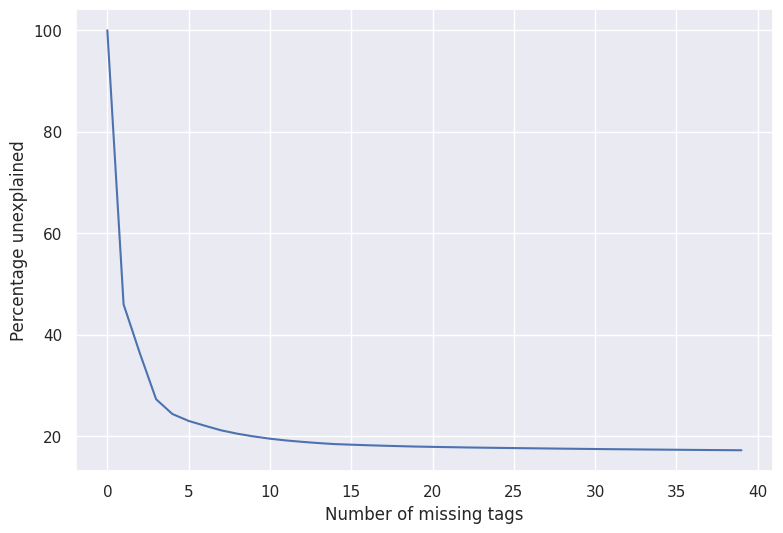

In [8]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(perc_list)
ax.set_xlabel('Number of missing tags')
ax.set_ylabel('Percentage unexplained');